# Image Classification

In this tutorial, we will use Tensorflow to develop a model which will classify images to be detected as either a dog or a cat.

First, we will need a few packages. **os** and **tensorflow** for our models, **matplotlib** to show results, along the way, and **random** to show some random images.

In [34]:
import os
import tensorflow as tf
from tensorflow.keras import utils, models, layers

import matplotlib.pyplot as plt
import random


The data which we will be using is a set of images of cats and dogs downloaded from the link https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

Then, we take our dataset and split them into batches for validation, testing, and training.

In [35]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


This function shows  a random set of 3 cats and 3 dogs from our dataset.

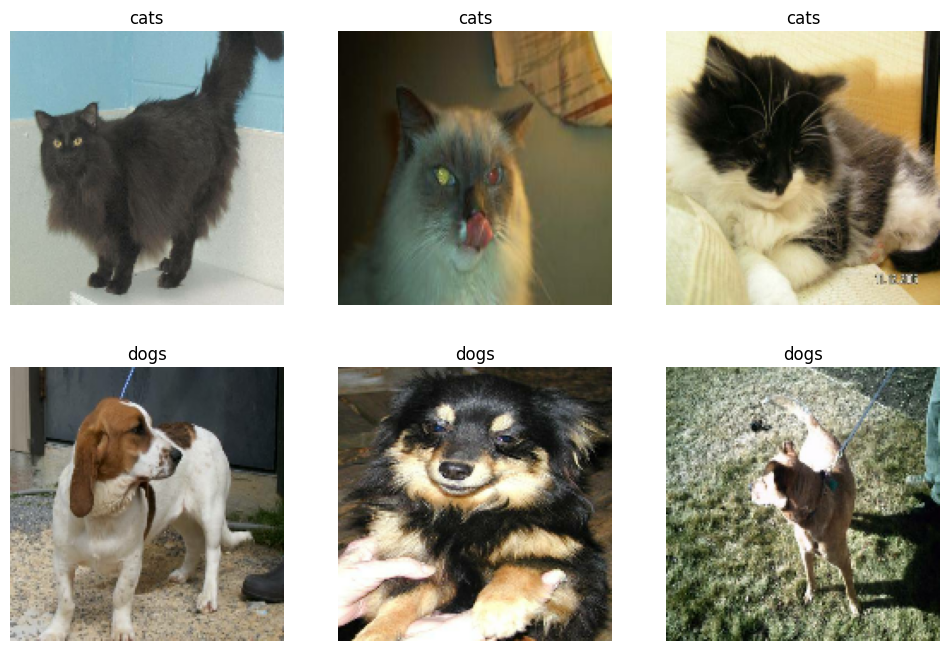

In [36]:
def showPets():
    global train_dataset

    class_names = train_dataset.class_names

    #shuffle the dataset so when we pick from the top, it is random
    train_dataset_show = train_dataset.shuffle(buffer_size=len(train_dataset))

    plt.figure(figsize=(12, 8))
    # Display three images of class 0
    for images, labels in train_dataset_show.take(1):
        for i in range(3):
            ax = plt.subplot(2, 3, i + 1)
            class_0_indices = [idx for idx, label in enumerate(labels) if label == 0]
            selected_index = class_0_indices[i]
            plt.imshow(images[selected_index].numpy().astype("uint8"))
            plt.title(class_names[labels[selected_index]])
            plt.axis("off")

    # Display three images of class 1
    for images, labels in train_dataset_show.take(1):
        for i in range(3):
            ax = plt.subplot(2, 3, i + 4)  # Start from the fourth subplot
            class_1_indices = [idx for idx, label in enumerate(labels) if label == 1]
            selected_index = class_1_indices[i]
            plt.imshow(images[selected_index].numpy().astype("uint8"))
            plt.title(class_names[labels[selected_index]])
            plt.axis("off")

    plt.show()

showPets()

We make a labels_iterator object to show how many images of each class we have. As you can see, we have 1000 cats and 1000 dogs.

In [37]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

In [38]:
dogs = 0
cats = 0
for i in labels_iterator:
    if i == 0:
        cats +=1
    else:
        dogs +=1
print(f"{cats} cats and {dogs} dogs")

1000 cats and 1000 dogs


The baseline machine learning model is the model that always guesses the most frequent label. Since there are an equal number of either class, the baseline is exactly 50% accurate. Lets see if we can make a model which beats that.

# First Model

In all models, we will be using models.Sequential to create a list of layers for our model to use to classify our classes. Then, we compile the model using an optimizer algorithm which the name "adam", a loss function built into the package, and measured on accuracy.



For model1, we will be using convolution using the **Conv2D** layer with a specified kernel to try to do detect shapes. **MaxPooling2D** selects the largest value in a specified kernel size to contrast the image and define classes. This process is alternated a few times. Then we use the **Flatten** layer to flatten our 2D layers into a 1D vector. Finally, we use the **Dense** layer to control the number of classes to divide the images into.

In [39]:
model1 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(2) # final number of classes
])


model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 52, 52, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 12544)            

To fit the model we use model1.fit() using the train_dataset we made earlier, 20 epochs, and validated using the validation_dataset.

In [41]:
history1 = model1.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 5s 52ms/step - loss: 7.8140 - accuracy: 0.4990 - val_loss: 0.6937 - val_accuracy: 0.5037
Epoch 2/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6932 - accuracy: 0.5140 - val_loss: 0.6931 - val_accuracy: 0.4851
Epoch 3/20
63/63 [==============================] - 4s 63ms/step - loss: 0.6861 - accuracy: 0.5270 - val_loss: 0.6834 - val_accuracy: 0.5582
Epoch 4/20
63/63 [==============================] - 3s 48ms/step - loss: 0.6642 - accuracy: 0.5960 - val_loss: 0.6857 - val_accuracy: 0.5074
Epoch 5/20
63/63 [==============================] - 3s 45ms/step - loss: 0.6793 - accuracy: 0.5030 - val_loss: 0.6846 - val_accuracy: 0.5074
Epoch 6/20
63/63 [==============================] - 4s 68ms/step - loss: 0.6501 - accuracy: 0.6105 - val_loss: 0.7199 - val_accuracy: 0.5371
Epoch 7/20
63/63 [==============================] - 3s 49ms/step - loss: 0.6222 - accuracy: 0.6380 - val_loss: 0.7482 - val_accuracy: 0.5792
Epoch 8/20
63

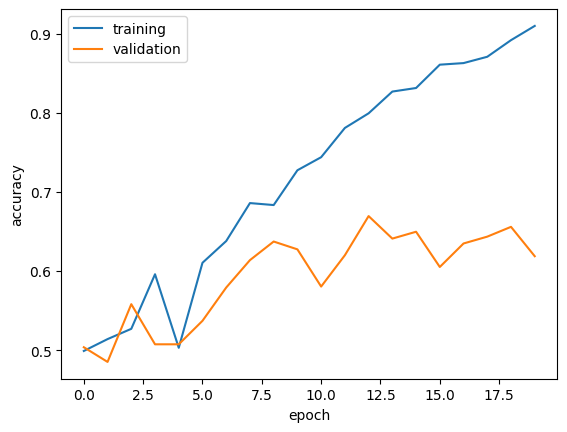

In [42]:
plt.plot(history1.history["accuracy"], label = "training")
plt.plot(history1.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

**The validation accuracy of the model stabilized between 55% and 65% during training.**

The baseline was 50%, so this is a huge increase in accuracy. The models which I tested was first the one given in class, adjusted for the imagae size and class count. Then, I tested different MaxPooling2D values as well as dropout positioning, which seemed to increase my validation accuracy. Overfitting is nothing short of a massive issue, as accuracy tended to 100%, whereas validation accuracy is not even close to that.

#  Model with Data Augmentation


To mitigate our overfitting issue, we are going to alter our images in a way that doesnt distort the image quality to introduce varity, and thus artificially increase the size of our dataset. In this case, we will be rotating the image in random directions.

Here is a plot of what an image would look like once a random flip layer is added over 9 samples.

In [43]:
flip = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
])

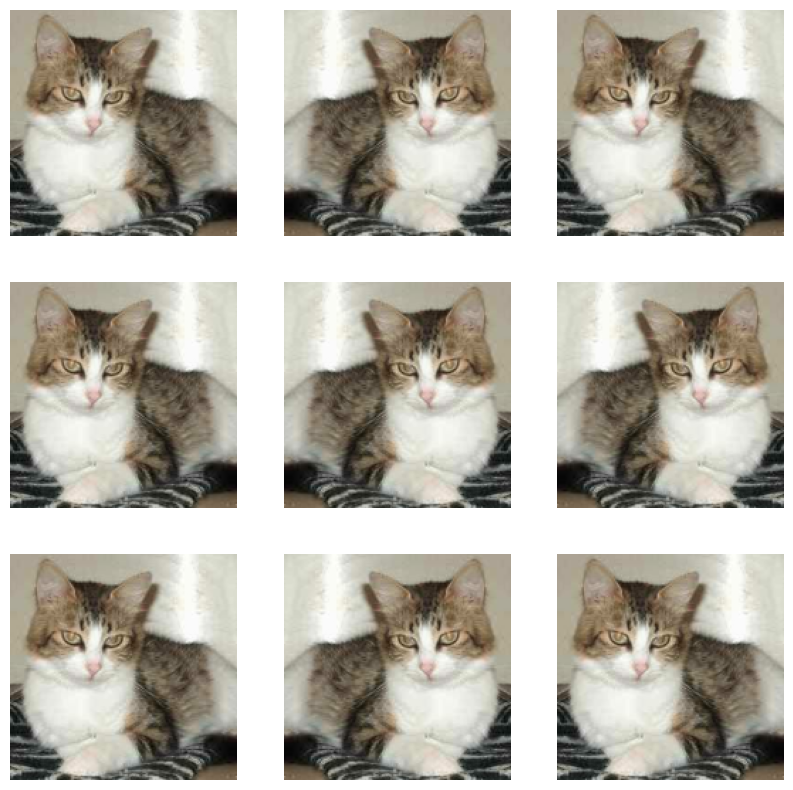

In [44]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = flip(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Here is a display of random rotation applied to an image over 9 samples.

In [45]:
rotate = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.2),
])

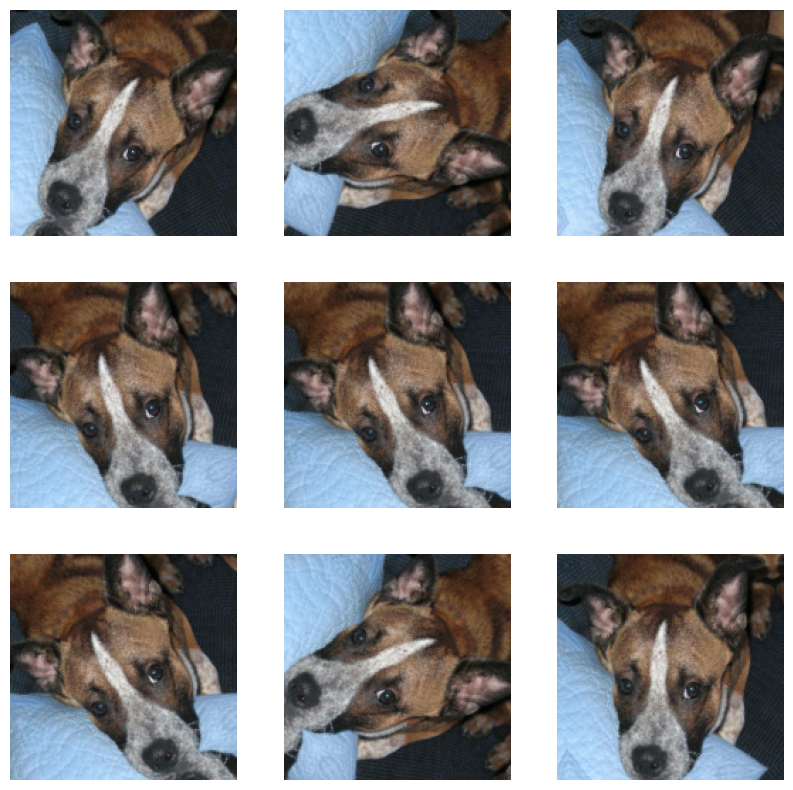

In [46]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = rotate(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Our model1 was better than the baseline, but to fix the overfitting problem, we augment some of the images and run the same model, calling it model2. We run it the exact same way we did for model1.

In [47]:
augmentation = models.Sequential([
    layers.RandomFlip('horizontal', input_shape=(160, 160, 3)),
    layers.RandomRotation(factor=0.2),
])

In [48]:
model2 = models.Sequential([
    augmentation,
    model1
])


model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 sequential_8 (Sequential)   (None, 2)                 831650    
                                                                 
Total params: 831650 (3.17 MB)
Trainable params: 831650 (3.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
history2 = model2.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 5s 55ms/step - loss: 0.7541 - accuracy: 0.5225 - val_loss: 0.6915 - val_accuracy: 0.5161
Epoch 2/20
63/63 [==============================] - 3s 48ms/step - loss: 0.6832 - accuracy: 0.5805 - val_loss: 0.6998 - val_accuracy: 0.5631
Epoch 3/20
63/63 [==============================] - 5s 75ms/step - loss: 0.6710 - accuracy: 0.5790 - val_loss: 0.6533 - val_accuracy: 0.6200
Epoch 4/20
63/63 [==============================] - 3s 48ms/step - loss: 0.6504 - accuracy: 0.6030 - val_loss: 0.6551 - val_accuracy: 0.6126
Epoch 5/20
63/63 [==============================] - 4s 54ms/step - loss: 0.6470 - accuracy: 0.6290 - val_loss: 0.6428 - val_accuracy: 0.6498
Epoch 6/20
63/63 [==============================] - 4s 53ms/step - loss: 0.6476 - accuracy: 0.6300 - val_loss: 0.6600 - val_accuracy: 0.6139
Epoch 7/20
63/63 [==============================] - 5s 69ms/step - loss: 0.6427 - accuracy: 0.6230 - val_loss: 0.6693 - val_accuracy: 0.6696
Epoch 8/20
63

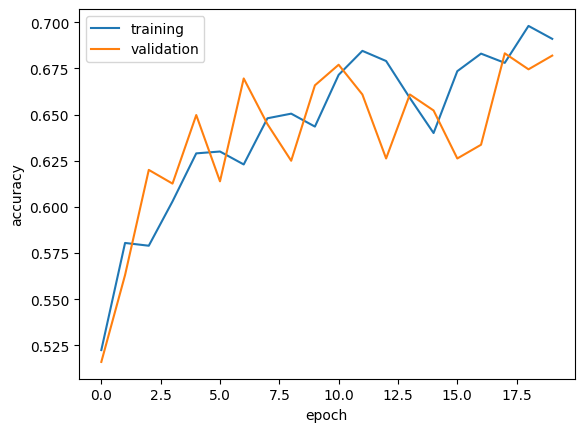

In [51]:
plt.plot(history2.history["accuracy"], label = "training")
plt.plot(history2.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

**The validation accuracy of the model stabilized between 60 to 70%% during training.**
Compared to model1, we can see a clear decrease in accuracy to around the range where the validation accuracy is. Additionally, the accuracy scores are around the same as in model 1. While the accuracies have not increased significantly, the accuracy and validation accuracy being close in value hints that we have successfully mitigated the overfitting problem.

# Data Preprocessing

Now, lets see what happens when we add a bit of preprocessing to our data. This only changes the values to a scale which the model can more easily handle, while not altering the meaning behind our data. Like before, we will run the exact same thing as model2 except with some preprocessing added first.

In [52]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

In [53]:
model3 = models.Sequential([
    preprocessor,
    model2
])


model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 160, 160, 3)       0         
                                                                 
 sequential_12 (Sequential)  (None, 2)                 831650    
                                                                 
Total params: 831650 (3.17 MB)
Trainable params: 831650 (3.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
history3 = model3.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 5s 50ms/step - loss: 8.4615 - accuracy: 0.5205 - val_loss: 0.6972 - val_accuracy: 0.4913
Epoch 2/20
63/63 [==============================] - 3s 46ms/step - loss: 0.6869 - accuracy: 0.5425 - val_loss: 0.6858 - val_accuracy: 0.5520
Epoch 3/20
63/63 [==============================] - 5s 79ms/step - loss: 0.6738 - accuracy: 0.5955 - val_loss: 0.6643 - val_accuracy: 0.6188
Epoch 4/20
63/63 [==============================] - 4s 54ms/step - loss: 0.6479 - accuracy: 0.6255 - val_loss: 0.6400 - val_accuracy: 0.6139
Epoch 5/20
63/63 [==============================] - 3s 48ms/step - loss: 0.6240 - accuracy: 0.6470 - val_loss: 0.6093 - val_accuracy: 0.6671
Epoch 6/20
63/63 [==============================] - 3s 47ms/step - loss: 0.6080 - accuracy: 0.6715 - val_loss: 0.5875 - val_accuracy: 0.6881
Epoch 7/20
63/63 [==============================] - 4s 54ms/step - loss: 0.5957 - accuracy: 0.6875 - val_loss: 0.6212 - val_accuracy: 0.6597
Epoch 8/20
63

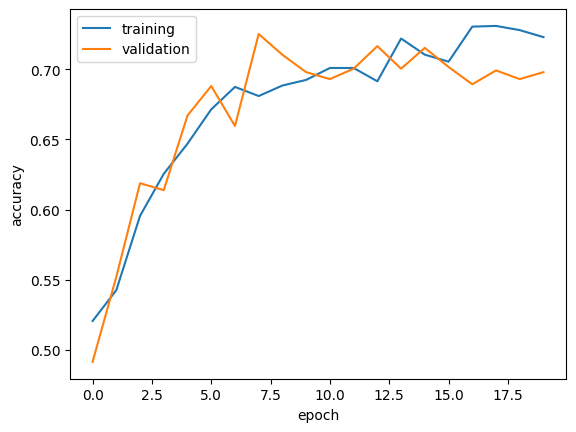

In [56]:
plt.plot(history3.history["accuracy"], label = "training")
plt.plot(history3.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

We can see a massive jump in both validation accuracy and training accuracy. **We can see that the validation accuracy jumps over 70% at the end**, a huge increase from before while still maintaining a similar accuracy score to the training, hinting that we do not have a overfitting concern.

# Transfer Learning

Preprocessing and augmentation clearly help our model, however the base model is based on convolution, which one can argue is not the best at determining what an image of a dog or cat looks like. In this next model, we will not be using our convolution method and instead be installing a different model which someone else has written, and using it for our purposes. We will call this the **base_model_layer**

In [57]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

We will still apply preprocessing, which simply makes things run smoother, and augmentation, which increases the number of sample images to feed our model. Then we will use **Flatten** and **Dense** to get our model to train for our 2 classes.

In [58]:
model4 = models.Sequential([
    preprocessor,
    augmentation,
    base_model_layer,
    layers.Flatten(),
    layers.Dense(2)
])


model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Notice how many parameters are in the imported model

In [59]:
model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 160, 160, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 model_3 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 flatten_3 (Flatten)         (None, 32000)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 64002     
                                                                 
Total params: 2321986 (8.86 MB)
Trainable params: 64002 (250.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [60]:
history4 = model4.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 9s 73ms/step - loss: 0.6128 - accuracy: 0.9115 - val_loss: 0.2768 - val_accuracy: 0.9666
Epoch 2/20
63/63 [==============================] - 4s 56ms/step - loss: 0.4899 - accuracy: 0.9365 - val_loss: 0.1311 - val_accuracy: 0.9827
Epoch 3/20
63/63 [==============================] - 5s 78ms/step - loss: 0.3119 - accuracy: 0.9555 - val_loss: 0.3278 - val_accuracy: 0.9579
Epoch 4/20
63/63 [==============================] - 4s 58ms/step - loss: 0.4038 - accuracy: 0.9545 - val_loss: 0.2109 - val_accuracy: 0.9827
Epoch 5/20
63/63 [==============================] - 4s 57ms/step - loss: 0.3666 - accuracy: 0.9555 - val_loss: 0.2052 - val_accuracy: 0.9802
Epoch 6/20
63/63 [==============================] - 4s 63ms/step - loss: 0.2418 - accuracy: 0.9660 - val_loss: 0.2958 - val_accuracy: 0.9728
Epoch 7/20
63/63 [==============================] - 7s 107ms/step - loss: 0.4612 - accuracy: 0.9615 - val_loss: 0.2790 - val_accuracy: 0.9790
Epoch 8/20
6

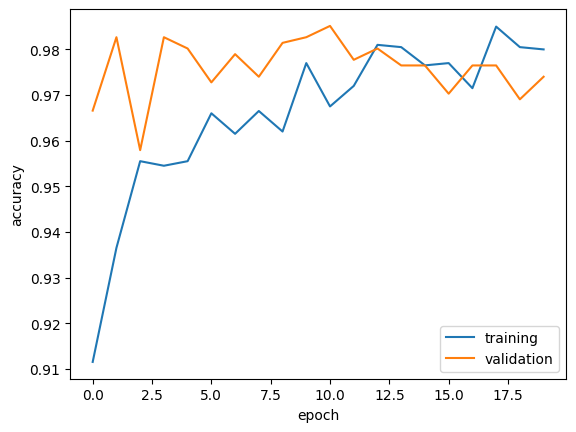

In [61]:
plt.plot(history4.history["accuracy"], label = "training")
plt.plot(history4.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

**We can see that our validation accuracy is at around 97%** This is an excellent score compared to our previous models. In addition, it appears that we our not to fear about overfitting, as the validation accuracy is still similar to the training accuracy.

In [62]:
#Test on unseen data
loss, accuracy = model4.evaluate(test_dataset)
print(f"accuracy is {accuracy*100}%")

6/6 [==============================] - 0s 38ms/step - loss: 0.3175 - accuracy: 0.9635
accuracy is 96.35416865348816%


Our model has produced a result of 98% accuracy on unseen data.